In [1]:
import pandas as pd

s_df = pd.read_csv("students.csv")
len(s_df)

318

In [2]:
s_df.head()

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350
3,4,0,0,0,301
4,5,1,0,0,317


In [3]:
s_df["student_id"]

0        1
1        2
2        3
3        4
4        5
      ... 
313    314
314    315
315    316
316    317
317    318
Name: student_id, Length: 318, dtype: int64

In [4]:
set(range(1, 319)) == set(s_df["student_id"].to_list())

True

In [6]:
s_df["gender"].value_counts()

gender
0    160
1    158
Name: count, dtype: int64

In [7]:
s_df["score"].describe()

count    318.000000
mean     303.644654
std       65.179995
min       88.000000
25%      261.000000
50%      310.000000
75%      350.000000
max      485.000000
Name: score, dtype: float64

<Axes: >

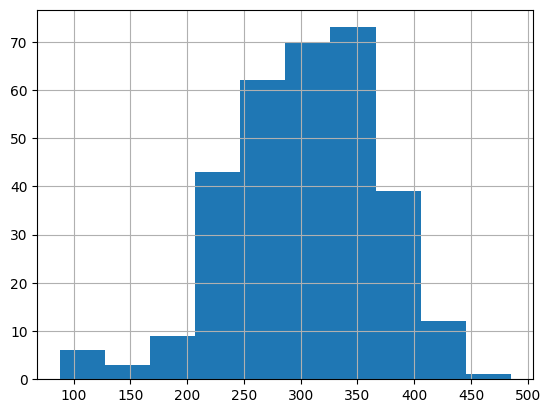

In [8]:
s_df["score"].hist()

In [9]:
s_df["leader_flag"].value_counts()

leader_flag
0    301
1     17
Name: count, dtype: int64

In [11]:
s_df["support_flag"].value_counts()

support_flag
0    314
1      4
Name: count, dtype: int64

In [12]:
s_pair_df = pd.read_csv("student_pairs.csv")
print(len(s_pair_df))

3


In [13]:
s_pair_df.head()

,student_id1,student_id2
0,118,189
1,72,50
2,314,233


In [17]:
import pulp

prob = pulp.LpProblem("ClassAssignmentProblem", pulp.LpMaximize)

S = s_df["student_id"].to_list()
C = ["A", "B", "C", "D", "E", "F", "G", "H"]
SC = [(s, c) for s in S for c in C]

X = pulp.LpVariable.dicts("x", SC, cat="Binary")

for s in S:
    prob += pulp.lpSum([X[s, c] for c in C]) == 1

for c in C:
    prob += pulp.lpSum([X[s, c] for s in S]) >= 39
    prob += pulp.lpSum([X[s, c] for s in S]) <= 40

S_male = [row.student_id for row in s_df.itertuples() if row.gender == 1]

S_female = [row.student_id for row in s_df.itertuples() if row.gender == 0]

for c in C:
    prob += pulp.lpSum([X[s, c] for s in S_male]) <= 20
    prob += pulp.lpSum([X[s, c] for s in S_female]) <= 20

score = {row.student_id: row.score for row in s_df.itertuples()}

score_mean = s_df["score"].mean()

for c in C:
    prob += (score_mean - 10) * pulp.lpSum([X[s, c] for s in S]) <= pulp.lpSum(
        [X[s, c] * score[s] for s in S]
    )
    prob += (score_mean + 10) * pulp.lpSum(
        [X[s, c] * score[s] for s in S]
    ) >= pulp.lpSum([X[s, c] for s in S])

S_leader = [row.student_id for row in s_df.itertuples() if row.leader_flag == 1]

for c in C:
    prob += pulp.lpSum([X[s, c] for s in S_leader]) >= 2

S_support = [row.student_id for row in s_df.itertuples() if row.support_flag == 1]

for c in C:
    prob += pulp.lpSum([X[s, c] for s in S_support]) <= 1

SS = [(row.student_id1, row.student_id2) for row in s_pair_df.itertuples()]

for s1, s2 in SS:
    prob += X[s1, c] + X[s2, c] <= 1

In [18]:
status = prob.solve()
print(status)
print(pulp.LpStatus[status])

1
Optimal


In [ ]:
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if X[s, c].value() == 1]

for c, Ss in C2Ss.items():
    print("Class:", c)
    print("Num:", len(Ss))
    print("Student:", Ss)
    print()